Parte 1: Introdução:
Esse notebook é o centro da entrega do HandsOn 01 e 02 da disciplina Banco de Dados e Big Data para Data Science o objetivo da ativade é migração de bancos de dados relacionais SQL para um formato NoSQL, para isso um banco de dados simples foi criado como exemplo e posteriormente esse banco foi adapatado para um banco NoSQL organizado em documentos, permitindo dessa maneira mais escabilidade e elasticidade.

In [1]:
# Importação de todas as bibliotecas necessárias
import pandas as pd
import json
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


Parte 2 Contexto: Para essa atividade foram criadas 3 Tabelas SQL: alunos, cursos, e matrículas. Um sistema acadêmico em que uma tabela guarda os dados dos alunos, outra os dados dos cursos, e uma terceira guarda as matrículas de determinados alunos, em determinados cursos. Um aluno pode se matricular, em vários cursos, um curso pode ter vários alunos, porém uma matrícula, guarda apenas um aluno, e um curso, além da nota, e do status da matrícula (matriculado, cancelado, concluido).
Depois de criado esta tabela no formato SQL e preencher com registros, as mesmas foram tranformadas em arquivos csv.


In [2]:
def carregar_csvs_final():
    """Carrega os CSVs já corrigidos"""
    print("📁 CARREGANDO CSVs CORRIGIDOS...")
    
    try:
        # Carregar os dados
        alunos_df = pd.read_csv('alunos.csv', delimiter=';', encoding='utf-8')
        cursos_df = pd.read_csv('cursos.csv', delimiter=';', encoding='utf-8')
        matriculas_df = pd.read_csv('matriculas.csv', delimiter=';', encoding='utf-8')
        
        # Limpar cabeçalhos
        def limpar_cabecalhos(df):
            df.columns = [col.replace("'", "").replace('"', '').strip().lower() for col in df.columns]
            return df
        
        alunos_df = limpar_cabecalhos(alunos_df)
        cursos_df = limpar_cabecalhos(cursos_df)
        matriculas_df = limpar_cabecalhos(matriculas_df)
        
        print("✅ CSVs carregados com sucesso!")
        print(f"👥 Alunos: {len(alunos_df)} registros")
        print(f"📚 Cursos: {len(cursos_df)} registros") 
        print(f"🎓 Matrículas: {len(matriculas_df)} registros")
        
        # Verificar se as colunas críticas existem
        print(f"\n🔍 VERIFICAÇÃO DE COLUNAS:")
        print(f"Alunos tem 'id': {'id' in alunos_df.columns}")
        print(f"Matrículas tem 'aluno_id': {'aluno_id' in matriculas_df.columns}")
        print(f"Matrículas tem 'curso_id': {'curso_id' in matriculas_df.columns}")
        
        return alunos_df, cursos_df, matriculas_df
        
    except Exception as e:
        print(f"❌ Erro ao carregar CSVs: {e}")
        return None, None, None

# Carregar dados
alunos_df, cursos_df, matriculas_df = carregar_csvs_final()

if alunos_df is not None:
    print("\n🎉 TODOS OS DADOS CARREGADOS CORRETAMENTE!")
else:
    print("❌ Falha no carregamento")

📁 CARREGANDO CSVs CORRIGIDOS...
✅ CSVs carregados com sucesso!
👥 Alunos: 20 registros
📚 Cursos: 20 registros
🎓 Matrículas: 20 registros

🔍 VERIFICAÇÃO DE COLUNAS:
Alunos tem 'id': True
Matrículas tem 'aluno_id': True
Matrículas tem 'curso_id': True

🎉 TODOS OS DADOS CARREGADOS CORRETAMENTE!


Depois de transformar os arquivos csv, em data frame, chega o momento de montar os arquivos JSON que serão os documentos, aqui foram usadas duas abordagens, as duas orientadas pela tabela alunos. Na primeira um grande documento, com todos os registros de alunos, e cada um desses regristros com as matrículas de cada aluna. A outra abordagem é criar um documento para cada aluno, e cada documento com todas matrículas do respectivo aluno.

In [3]:
class SQLtoNoSQLMigrator:
    def __init__(self, alunos_df, cursos_df, matriculas_df):
        self.alunos_df = alunos_df
        self.cursos_df = cursos_df
        self.matriculas_df = matriculas_df
        self.documentos_alunos = []
        
    def analisar_dados(self):
        """Faz análise exploratória dos dados"""
        print("\n🔍 ANÁLISE EXPLORATÓRIA DOS DADOS")
        print("=" * 50)
        
        # 1. Análise de Alunos
        print("\n👥 ALUNOS:")
        print(f"Total: {len(self.alunos_df)}")
        print("Status:")
        print(self.alunos_df['status'].value_counts())
        
        # 2. Análise de Cursos
        print("\n📚 CURSOS:")
        print(f"Total: {len(self.cursos_df)}")
        print("Créditos:")
        print(self.cursos_df['creditos'].value_counts().sort_index())
        
        # 3. Análise de Matrículas
        print("\n🎓 MATRÍCULAS:")
        print(f"Total: {len(self.matriculas_df)}")
        print("Status:")
        print(self.matriculas_df['status'].value_counts())
        
        # Relacionamentos
        print("\n🔗 RELACIONAMENTOS:")
        matriculas_por_aluno = self.matriculas_df.groupby('aluno_id').size()
        print(f"Matrículas por aluno - Média: {matriculas_por_aluno.mean():.1f}")
        
    def migrar_para_nosql(self):
        """Realiza a migração para estrutura NoSQL"""
        print("\n🔄 INICIANDO MIGRAÇÃO PARA NOSQL...")
        
        self.documentos_alunos = []
        
        for index, aluno in self.alunos_df.iterrows():
            aluno_id = aluno['id']
            
            if index % 5 == 0:
                print(f"🔄 Processando aluno {index + 1}/{len(self.alunos_df)}...")
            
            # Buscar matrículas do aluno
            matriculas_aluno = self.matriculas_df[self.matriculas_df['aluno_id'] == aluno_id]
            matriculas_formatadas = []
            
            for _, matricula in matriculas_aluno.iterrows():
                curso_id = matricula['curso_id']
                
                # Buscar curso
                curso_match = self.cursos_df[self.cursos_df['id'] == curso_id]
                if not curso_match.empty:
                    curso_info = curso_match.iloc[0]
                    
                    # Tratar nota
                    nota = matricula.get('nota', 0)
                    if pd.isna(nota) or nota == '\\N':
                        nota = 0.0
                    
                    matricula_doc = {
                        'matricula_id': int(matricula['id']),
                        'curso_id': int(curso_id),
                        'data_matricula': matricula.get('data_matricula', ''),
                        'status': matricula.get('status', ''),
                        'nota': float(nota),
                        'criado_em': matricula.get('criado_em', ''),
                        'curso_info': {
                            'codigo': curso_info.get('codigo', ''),
                            'nome': curso_info['nome'],
                            'descricao': curso_info.get('descricao', ''),
                            'creditos': int(curso_info.get('creditos', 0)),
                            'capacidade': int(curso_info.get('capacidade', 0)),
                            'categoria': self._extrair_categoria(curso_info.get('nome', ''))
                        }
                    }
                    matriculas_formatadas.append(matricula_doc)
            
            # Criar documento do aluno
            aluno_doc = {
                'aluno_id': int(aluno_id),
                'numero_matricula': aluno.get('numero_matricula', ''),
                'nome': aluno['nome'],
                'email': aluno.get('email', ''),
                'data_nascimento': aluno.get('data_nascimento', ''),
                'data_ingresso': aluno.get('data_ingresso', ''),
                'status_aluno': aluno.get('status', ''),
                'criado_em': aluno.get('criado_em', ''),
                'matriculas': matriculas_formatadas,
                'total_matriculas': len(matriculas_formatadas),
                'matriculas_ativas': len([m for m in matriculas_formatadas if m.get('status') == 'matriculado']),
                'matriculas_concluidas': len([m for m in matriculas_formatadas if m.get('status') == 'concluido']),
                'matriculas_canceladas': len([m for m in matriculas_formatadas if m.get('status') == 'cancelado'])
            }
            
            self.documentos_alunos.append(aluno_doc)
        
        print(f"✅ Migração concluída: {len(self.documentos_alunos)} documentos criados")
        return self.documentos_alunos
    
    def _extrair_categoria(self, nome_curso):
        """Extrai categoria do curso"""
        nome_curso = nome_curso.lower()
        
        categorias = {
            'Matemática': ['matemática', 'cálculo', 'álgebra', 'estatística'],
            'Programação': ['programação', 'python', 'desenvolvimento', 'banco de dados', 'sql'],
            'Ciências': ['física', 'biologia', 'química'],
            'Tecnologia': ['sistemas', 'redes', 'ia', 'engenharia de software', 'ux'],
            'Humanas': ['história', 'inglês', 'economia', 'empreendedorismo', 'gestão']
        }
        
        for categoria, palavras in categorias.items():
            if any(palavra in nome_curso for palavra in palavras):
                return categoria
        return 'Geral'
    
    def salvar_resultados(self):
        """Salva os documentos em JSON"""
        if not self.documentos_alunos:
            print("❌ Nenhum documento para salvar")
            return
            
        print("\n💾 SALVANDO RESULTADOS...")
        
        try:
            # Arquivo único
            with open('documentos_alunos.json', 'w', encoding='utf-8') as f:
                json.dump(self.documentos_alunos, f, indent=2, ensure_ascii=False)
            print("✅ documentos_alunos.json salvo")
            
            # Documentos individuais
            os.makedirs('documentos_individual', exist_ok=True)
            for doc in self.documentos_alunos:
                nome_arquivo = f"aluno_{doc['aluno_id']}.json"
                with open(f'documentos_individual/{nome_arquivo}', 'w', encoding='utf-8') as f:
                    json.dump(doc, f, indent=2, ensure_ascii=False)
            print(f"✅ {len(self.documentos_alunos)} documentos individuais salvos")
            
            # Estatísticas
            total_matriculas = sum(doc['total_matriculas'] for doc in self.documentos_alunos)
            print(f"\n📊 ESTATÍSTICAS:")
            print(f"Alunos: {len(self.documentos_alunos)}")
            print(f"Matrículas totais: {total_matriculas}")
            print(f"Média por aluno: {total_matriculas/len(self.documentos_alunos):.1f}")
            
        except Exception as e:
            print(f"❌ Erro ao salvar: {e}")

# Instanciar migrador
if alunos_df is not None:
    migrator = SQLtoNoSQLMigrator(alunos_df, cursos_df, matriculas_df)
    print("✅ Migrador instanciado com sucesso!")
else:
    print("❌ Não foi possível instanciar o migrador")

✅ Migrador instanciado com sucesso!


In [4]:
# VERIFICAR RESULTADOS
print("🔍 VERIFICANDO RESULTADOS...")

if os.path.exists('documentos_alunos.json'):
    with open('documentos_alunos.json', 'r', encoding='utf-8') as f:
        dados = json.load(f)
    print(f"✅ Arquivo principal: {len(dados)} documentos")
    
if os.path.exists('documentos_individual'):
    arquivos = os.listdir('documentos_individual')
    print(f"✅ Documentos individuais: {len(arquivos)} arquivos")
    
    # Mostrar exemplo do primeiro documento
    if arquivos:
        with open(f'documentos_individual/{arquivos[0]}', 'r', encoding='utf-8') as f:
            exemplo = json.load(f)
        print(f"\n📄 Exemplo do primeiro documento:")
        print(f"Aluno: {exemplo['nome']}")
        print(f"ID: {exemplo['aluno_id']}")
        print(f"Matrículas: {exemplo['total_matriculas']}")

🔍 VERIFICANDO RESULTADOS...
✅ Arquivo principal: 20 documentos
✅ Documentos individuais: 20 arquivos

📄 Exemplo do primeiro documento:
Aluno: João Martins
ID: 10
Matrículas: 1


In [5]:
# EXECUTAR MIGRAÇÃO COMPLETA
if alunos_df is not None:
    print("🚀 EXECUTANDO MIGRAÇÃO...")
    documentos = migrator.migrar_para_nosql()
    
    print(f"\n🎉 MIGRAÇÃO CONCLUÍDA!")
    print(f"📄 Total de documentos criados: {len(documentos)}")
    
    # Mostrar exemplo do primeiro documento
    if documentos:
        print(f"\n📋 EXEMPLO DO PRIMEIRO DOCUMENTO:")
        primeiro_doc = documentos[0]
        print(f"Aluno: {primeiro_doc['nome']}")
        print(f"Matrícula: {primeiro_doc['numero_matricula']}")
        print(f"Status: {primeiro_doc['status_aluno']}")
        print(f"Total de matrículas: {primeiro_doc['total_matriculas']}")
        print(f"Matrículas ativas: {primeiro_doc['matriculas_ativas']}")
        
        if primeiro_doc['matriculas']:
            print(f"\n📚 Matrículas do aluno:")
            for matricula in primeiro_doc['matriculas']:
                print(f"  - {matricula['curso_info']['nome']} ({matricula['status']}) - Nota: {matricula['nota']}")
else:
    print("❌ Não é possível executar a migração - dados não carregados")

🚀 EXECUTANDO MIGRAÇÃO...

🔄 INICIANDO MIGRAÇÃO PARA NOSQL...
🔄 Processando aluno 1/20...
🔄 Processando aluno 6/20...
🔄 Processando aluno 11/20...
🔄 Processando aluno 16/20...
✅ Migração concluída: 20 documentos criados

🎉 MIGRAÇÃO CONCLUÍDA!
📄 Total de documentos criados: 20

📋 EXEMPLO DO PRIMEIRO DOCUMENTO:
Aluno: Ana Silva
Matrícula: 20230001
Status: ativo
Total de matrículas: 2
Matrículas ativas: 2

📚 Matrículas do aluno:
  - Introdução à Programação (matriculado) - Nota: 0.0
  - Banco de Dados (matriculado) - Nota: 0.0


In [6]:
import json
import os

def salvar_resultados(self):
    """Salva os documentos em JSON"""
    if not self.documentos_alunos:
        print("❌ Nenhum documento para salvar")
        return
        
    print("\n💾 SALVANDO RESULTADOS...")
    
    try:
        # Salvar arquivo único
        with open('documentos_alunos.json', 'w', encoding='utf-8') as f:
            json.dump(self.documentos_alunos, f, indent=2, ensure_ascii=False)
        print("✅ Documento único salvo: documentos_alunos.json")
        
        # Salvar documentos individuais
        if not os.path.exists('documentos_individual'):
            os.makedirs('documentos_individual')
            
        for doc in self.documentos_alunos:
            nome_safe = doc['nome'].replace(' ', '_').replace('/', '_')
            filename = f"aluno_{doc['aluno_id']}_{doc['numero_matricula']}_{nome_safe}.json"
            filepath = os.path.join('documentos_individual', filename)
            
            with open(filepath, 'w', encoding='utf-8') as f:
                json.dump(doc, f, indent=2, ensure_ascii=False)
                
        print(f"✅ {len(self.documentos_alunos)} documentos individuais salvos em: documentos_individual/")
        
        # Mostrar estatísticas
        total_matriculas = sum(doc['total_matriculas'] for doc in self.documentos_alunos)
        print(f"\n📊 ESTATÍSTICAS FINAIS:")
        print(f"Alunos: {len(self.documentos_alunos)}")
        print(f"Matrículas totais: {total_matriculas}")
        print(f"Matrículas ativas: {sum(doc['matriculas_ativas'] for doc in self.documentos_alunos)}")
        print(f"Matrículas concluídas: {sum(doc['matriculas_concluidas'] for doc in self.documentos_alunos)}")
        
    except Exception as e:
        print(f"❌ Erro ao salvar: {e}")

# Adicionar método à classe
SQLtoNoSQLMigrator.salvar_resultados = salvar_resultados

# Salvar resultados
if alunos_df is not None and hasattr(migrator, 'documentos_alunos') and migrator.documentos_alunos:
    migrator.salvar_resultados()


💾 SALVANDO RESULTADOS...
✅ Documento único salvo: documentos_alunos.json
✅ 20 documentos individuais salvos em: documentos_individual/

📊 ESTATÍSTICAS FINAIS:
Alunos: 20
Matrículas totais: 20
Matrículas ativas: 8
Matrículas concluídas: 11


Em ambos os casos, foi usado "embedding" no lugar do "referencing" se antes as matrículas no SQL guardavam os ids dos alunos e dos cursos, agora ao acessar um aluno vc já acessa a sua matrícula por exemplo antes tinhamos o registro na tabela matrícula {
    ID";"ALUNO_ID";"CURSO_ID";"DATA_MATRICULA";"STATUS";"NOTA";"CRIADO_EM"
    "61";"1";"6";"2024-03-01";"matriculado";\N;"2025-11-12 14:08:36"
} agora no documento indiviudal do aluno com ID 1, matriculado no curso 6 {
  "aluno_id": 1,
  "numero_matricula": 20230001,
  "nome": "Ana Silva",
  "email": "ana.silva@example.com",
  "data_nascimento": "2001-05-14",
  "data_ingresso": "2023-03-01",
  "status_aluno": "ativo",
  "criado_em": "2025-11-12 13:15:48",
  "matriculas": [
    {
      "matricula_id": 61,
      "curso_id": 6,
      "data_matricula": "2024-03-01",
      "status": "matriculado",
      "nota": 0.0,
      "criado_em": "2025-11-12 14:08:36",
      "curso_info": {
        "codigo": "PROG101",
        "nome": "Introdução à Programação",
        "descricao": "Lógica de programação e algoritmos",
        "creditos": 4,
        "capacidade": 80,
        "categoria": "Programação"
      }
    },
    {
      "matricula_id": 62,
      "curso_id": 7,
      "data_matricula": "2024-03-02",
      "status": "matriculado",
      "nota": 0.0,
      "criado_em": "2025-11-12 14:08:36",
      "curso_info": {
        "codigo": "BD101",
        "nome": "Banco de Dados",
        "descricao": "Modelagem relacional e SQL",
        "creditos": 4,
        "capacidade": 50,
        "categoria": "Programação"
      }
    }
  ],
  "total_matriculas": 2,
  "matriculas_ativas": 2,
  "matriculas_concluidas": 0,
  "matriculas_canceladas": 0
}
O uso de embedding foi escolhido porque a operação mais frequente no cenário acadêmico é consultar um aluno e suas matrículas de maneira conjunta. Como o volume de matrículas por aluno é limitado e estável, o embedding reduz a necessidade de joins, melhora o desempenho em leituras agregadas e simplifica o modelo. Referencing seria mais adequado apenas se as matrículas fossem acessadas independentemente dos alunos.

In [4]:
# --- Conexão e inserção dos documentos JSON no MongoDB Atlas ---

import json
from pymongo import MongoClient

# -----------------------------------------------
# 1. Connection string para o MongoDB Atlas
# (substitua <SUA_SENHA> pela senha do usuário)
# -----------------------------------------------
connection_string = connection_string = (
    "mongodb+srv://henriquepardo_db_user:fc5f5dY46lQ4arQi"
    "@bancoalunoshandson.ji2rtcz.mongodb.net/"
    "?retryWrites=true&w=majority&authSource=admin"
)

client = MongoClient(connection_string)

# Nome do banco e coleção (pode alterar se quiser)
db = client["hands_on_bd"]
collection = db["alunos"]

# -----------------------------------------------
# 2. Carregar o arquivo JSON gerado
# (ajuste o caminho se estiver em outra pasta)
# -----------------------------------------------
json_file = "documentos_alunos.json"

with open(json_file, "r", encoding="utf-8") as f:
    documentos = json.load(f)

# Caso seja um array JSON, inserir tudo de uma vez
if isinstance(documentos, list):
    result = collection.insert_many(documentos)
    print(f"{len(result.inserted_ids)} documentos inseridos.")
else:
    result = collection.insert_one(documentos)
    print("1 documento inserido.")

# -----------------------------------------------
# 3. Verificação da migração
# -----------------------------------------------
print("\nExemplo de documento inserido:")
print(collection.find_one())


20 documentos inseridos.

Exemplo de documento inserido:
{'_id': ObjectId('692dfee5556fd8de1dcf42ad'), 'aluno_id': 1, 'numero_matricula': 20230001, 'nome': 'Ana Silva', 'email': 'ana.silva@example.com', 'data_nascimento': '2001-05-14', 'data_ingresso': '2023-03-01', 'status_aluno': 'ativo', 'criado_em': '2025-11-12 13:15:48', 'matriculas': [{'matricula_id': 61, 'curso_id': 6, 'data_matricula': '2024-03-01', 'status': 'matriculado', 'nota': 0.0, 'criado_em': '2025-11-12 14:08:36', 'curso_info': {'codigo': 'PROG101', 'nome': 'Introdução à Programação', 'descricao': 'Lógica de programação e algoritmos', 'creditos': 4, 'capacidade': 80, 'categoria': 'Programação'}}, {'matricula_id': 62, 'curso_id': 7, 'data_matricula': '2024-03-02', 'status': 'matriculado', 'nota': 0.0, 'criado_em': '2025-11-12 14:08:36', 'curso_info': {'codigo': 'BD101', 'nome': 'Banco de Dados', 'descricao': 'Modelagem relacional e SQL', 'creditos': 4, 'capacidade': 50, 'categoria': 'Programação'}}], 'total_matriculas': 

📈 ANÁLISES DESCRITIVAS DOS DADOS
🎯 VISÃO GERAL DA BASE DE DADOS
----------------------------------------
👥 Total de alunos: 20
🎓 Total de matrículas: 20
📊 Média de matrículas por aluno: 1.00

📋 DISTRIBUIÇÃO POR STATUS:
  ativo: 18 alunos (90.0%)
  inativo: 2 alunos (10.0%)

🎓 STATUS DAS MATRÍCULAS:
  ✅ Ativas: 8
  🎯 Concluídas: 11
  ❌ Canceladas: 1

🏆 TOP 5 CURSOS MAIS POPULARES:
  Introdução à Programação: 5 matrículas
  Banco de Dados: 2 matrículas
  Cálculo I: 2 matrículas
  Matemática Básica: 2 matrículas
  Física Geral: 1 matrículas

📚 DISTRIBUIÇÃO POR CATEGORIA:
  Programação: 8 matrículas (40.0%)
  Matemática: 6 matrículas (30.0%)
  Ciências: 2 matrículas (10.0%)
  Tecnologia: 2 matrículas (10.0%)
  Humanas: 2 matrículas (10.0%)

⭐ TOP 5 ALUNOS COM MAIS MATRÍCULAS:
  1. Ana Silva: 2 matrículas
  2. Bruno Oliveira: 2 matrículas
  3. Carla Pereira: 1 matrículas
  4. Diego Costa: 1 matrículas
  5. Érica Santos: 1 matrículas

📊 ANÁLISE DE NOTAS (CURSOS CONCLUÍDOS):
  Média: 7.83
  M

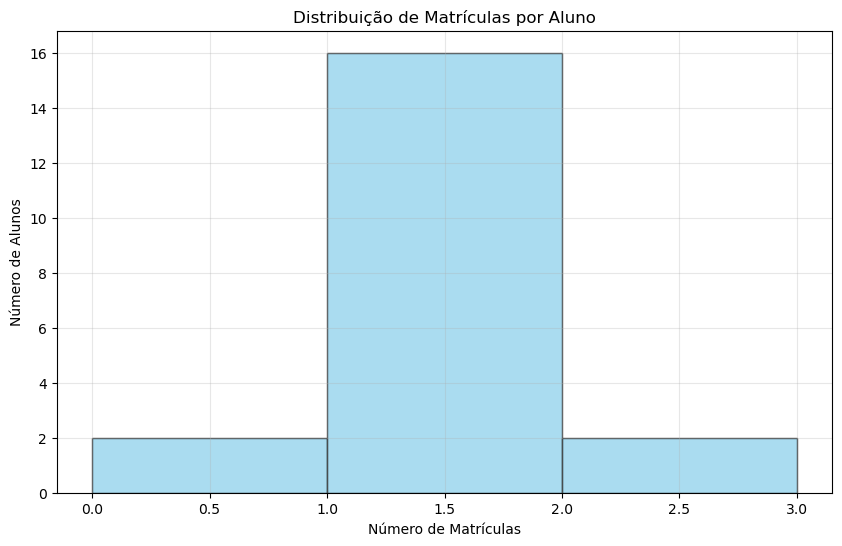

In [7]:
# 📊 ANÁLISES DESCRITIVAS SIMPLES
print("📈 ANÁLISES DESCRITIVAS DOS DADOS")
print("=" * 50)

def analises_descritivas(documentos):
    """Realiza análises descritivas básicas nos dados"""
    
    print("🎯 VISÃO GERAL DA BASE DE DADOS")
    print("-" * 40)
    
    # Estatísticas básicas
    total_alunos = len(documentos)
    total_matriculas = sum(aluno['total_matriculas'] for aluno in documentos)
    
    print(f"👥 Total de alunos: {total_alunos}")
    print(f"🎓 Total de matrículas: {total_matriculas}")
    print(f"📊 Média de matrículas por aluno: {total_matriculas/total_alunos:.2f}")
    
    # Status dos alunos
    print(f"\n📋 DISTRIBUIÇÃO POR STATUS:")
    status_alunos = {}
    for aluno in documentos:
        status = aluno['status_aluno']
        status_alunos[status] = status_alunos.get(status, 0) + 1
    
    for status, count in status_alunos.items():
        percentual = (count / total_alunos) * 100
        print(f"  {status}: {count} alunos ({percentual:.1f}%)")
    
    # Matrículas por status
    print(f"\n🎓 STATUS DAS MATRÍCULAS:")
    matriculas_ativas = sum(aluno['matriculas_ativas'] for aluno in documentos)
    matriculas_concluidas = sum(aluno['matriculas_concluidas'] for aluno in documentos)
    matriculas_canceladas = sum(aluno['matriculas_canceladas'] for aluno in documentos)
    
    print(f"  ✅ Ativas: {matriculas_ativas}")
    print(f"  🎯 Concluídas: {matriculas_concluidas}")
    print(f"  ❌ Canceladas: {matriculas_canceladas}")
    
    # Análise de cursos mais populares
    print(f"\n🏆 TOP 5 CURSOS MAIS POPULARES:")
    cursos_populares = {}
    for aluno in documentos:
        for matricula in aluno['matriculas']:
            curso_nome = matricula['curso_info']['nome']
            cursos_populares[curso_nome] = cursos_populares.get(curso_nome, 0) + 1
    
    for curso, count in sorted(cursos_populares.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {curso}: {count} matrículas")
    
    # Análise de categorias
    print(f"\n📚 DISTRIBUIÇÃO POR CATEGORIA:")
    categorias = {}
    for aluno in documentos:
        for matricula in aluno['matriculas']:
            categoria = matricula['curso_info']['categoria']
            categorias[categoria] = categorias.get(categoria, 0) + 1
    
    for categoria, count in sorted(categorias.items(), key=lambda x: x[1], reverse=True):
        percentual = (count / total_matriculas) * 100
        print(f"  {categoria}: {count} matrículas ({percentual:.1f}%)")
    
    # Alunos mais ativos
    print(f"\n⭐ TOP 5 ALUNOS COM MAIS MATRÍCULAS:")
    alunos_ativos = sorted(documentos, key=lambda x: x['total_matriculas'], reverse=True)[:5]
    for i, aluno in enumerate(alunos_ativos, 1):
        print(f"  {i}. {aluno['nome']}: {aluno['total_matriculas']} matrículas")
    
    # Análise de notas (apenas cursos concluídos)
    print(f"\n📊 ANÁLISE DE NOTAS (CURSOS CONCLUÍDOS):")
    notas = []
    for aluno in documentos:
        for matricula in aluno['matriculas']:
            if matricula['status'] == 'concluido' and matricula['nota'] > 0:
                notas.append(matricula['nota'])
    
    if notas:
        print(f"  Média: {sum(notas)/len(notas):.2f}")
        print(f"  Maior nota: {max(notas):.2f}")
        print(f"  Menor nota: {min(notas):.2f}")
        print(f"  Total de cursos concluídos: {len(notas)}")
    else:
        print("  Nenhuma nota disponível para análise")

# Gerar visualizações simples
def gerar_visualizacoes(documentos):
    """Gera visualizações básicas dos dados"""
    import matplotlib.pyplot as plt
    
    print(f"\n📊 GERANDO VISUALIZAÇÕES...")
    
    # Dados para gráficos
    status_alunos = {}
    categorias_cursos = {}
    
    for aluno in documentos:
        status = aluno['status_aluno']
        status_alunos[status] = status_alunos.get(status, 0) + 1
        
        for matricula in aluno['matriculas']:
            categoria = matricula['curso_info']['categoria']
            categorias_cursos[categoria] = categorias_cursos.get(categoria, 0) + 1
    
    # Gráfico 1: Status dos alunos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.pie(status_alunos.values(), labels=status_alunos.keys(), autopct='%1.1f%%', startangle=90)
    ax1.set_title('Distribuição por Status dos Alunos')
    
    # Gráfico 2: Categorias de cursos
    ax2.pie(categorias_cursos.values(), labels=categorias_cursos.keys(), autopct='%1.1f%%', startangle=90)
    ax2.set_title('Distribuição por Categoria de Curso')
    
    plt.tight_layout()
    plt.show()
    
    # Gráfico 3: Matrículas por aluno
    plt.figure(figsize=(10, 6))
    matriculas_por_aluno = [aluno['total_matriculas'] for aluno in documentos]
    plt.hist(matriculas_por_aluno, bins=range(0, max(matriculas_por_aluno) + 2), 
             alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Distribuição de Matrículas por Aluno')
    plt.xlabel('Número de Matrículas')
    plt.ylabel('Número de Alunos')
    plt.grid(True, alpha=0.3)
    plt.show()

# Executar análises
if hasattr(migrator, 'documentos_alunos') and migrator.documentos_alunos:
    analises_descritivas(migrator.documentos_alunos)
    gerar_visualizacoes(migrator.documentos_alunos)
else:
    print("❌ Nenhum documento disponível para análise")

Por ultimo e para exemplificar como o acesso as informações fica simples, alguma analíses foram feitas e gráficos elaborados. É importante, reinterar que o banco usado de exemplo é bem simples por exemplo não há uma tabela de professores, que possivelmente seria um outro documento, mas para fins didáticos esse exemplo foi útil para mostra como adaptações são possíveis e em um datalake que já tenha uma predilecência a bancos NoSQL. A migração para NoSQL traz maior elasticidade e escalabilidade, mas reduz a integridade referencial automática presente no modelo relacional. Como dados de cursos aparecem repetidos dentro de cada matrícula, é necessário cuidado para evitar inconsistências. A leitura fica mais eficiente, mas atualizações podem exigir reescrita de múltiplos documentos, um trade-off clássico da denormalização.